In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

try:
    from premier_league import (
        constants,
        preprocessing,
        preprocessing_helpers,
        training,
        evaluation,
        prediction,
        data_extraction,
        visualisations,
        s3_helpers,
        postgres,
        mlflow_functions,
        expectations_helpers,
        email_functions,
        data_drift_functions,
    )
except ModuleNotFoundError:
    import constants
    import preprocessing
    import preprocessing_helpers
    import training
    import evaluation
    import prediction
    import data_extraction
    import visualisations
    import s3_helpers
    import postgres
    import mlflow_functions
    import expectations_helpers
    import email_functions
    import data_drift_functions

2023-11-24 18:20:44,692 - PremierLeagueLogger - INFO - Grabbing Passwords


In [2]:
import importlib
importlib.reload(constants)


<module 'premier_league.constants' from '/Users/david@inawisdom.com/Documents/Training/premier_league/notebooks/../premier_league/constants.py'>

In [3]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

2023-11-24 18:20:48,708 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-24 18:20:53,558 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [4]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [5]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = expectations_helpers.AutoGreatExpectations(df)

In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

Generating expectations
Done


In [7]:
if constants.RUN_DATA_EXPECTATIONS:
    expectations_helpers.view_suite_summary(ge_data)

2023-11-24 18:20:54,615 - PremierLeagueLogger - INFO - Total Expectations: 18
2023-11-24 18:20:55,568 - PremierLeagueLogger - INFO - Counts:
2023-11-24 18:20:56,584 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1


expect_table_columns_to_match_set: 1


2023-11-24 18:20:57,711 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2


expect_column_values_to_be_between: 2


2023-11-24 18:20:58,660 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7


expect_column_values_to_be_of_type: 7


2023-11-24 18:20:59,954 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7


expect_column_values_to_be_null: 7


2023-11-24 18:21:01,239 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1


expect_column_values_to_be_in_set: 1


In [8]:
# Save expectations to S3
expectations_helpers.save_expectations(
    ge_data,
    f'app_data/expectations/exp_prem_results_{constants.current_time}.json'
)

2023-11-24 18:21:02,269 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/exp_prem_results_20231124.json
2023-11-24 18:21:04,415 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/exp_prem_results_20231124.json


### Validate data

In [9]:
# Load latest expectations
data_expectations = expectations_helpers.load_latest_expectations(
    expectations_helpers.latest_exp_file()
)

2023-11-24 18:21:06,255 - PremierLeagueLogger - INFO - Looking for latest expectations file
2023-11-24 18:21:07,359 - PremierLeagueLogger - INFO - Loading expectations from premier-league-app/app_data/expectations/exp_prem_results_20231124.json
2023-11-24 18:21:09,423 - PremierLeagueLogger - INFO - Loaded expectations from premier-league-app/app_data/expectations/exp_prem_results_20231124.json


In [10]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION
    )


2023-11-24 18:21:10,506 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-24 18:21:13,076 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [11]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

2023-11-24 18:21:14,096 - PremierLeagueLogger - INFO - Trying to read data from https://www.football-data.co.uk/mmz4281/2324/E0.csv
2023-11-24 18:21:16,369 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/training_data_full.csv
2023-11-24 18:21:22,257 - PremierLeagueLogger - INFO - Data saved at app_data/training_data_full.csv


In [12]:
validation_results = expectations_helpers.validate_data(
        full_data, 
        data_expectations,
        expectations_path = constants.VALIDATION_RESULTS_PATH
)

2023-11-24 18:21:23,594 - PremierLeagueLogger - INFO - {'evaluated_expectations': 18, 'successful_expectations': 18, 'unsuccessful_expectations': 0, 'success_percent': 100.0}
2023-11-24 18:21:24,564 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/valid_results_20231124.json
2023-11-24 18:21:26,588 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/valid_results_20231124.json


In [13]:
if not validation_results['success']:
    email_functions.send_email(
        'data_validation',
        constants.S3_BUCKET, 
        expectations_helpers.latest_exp_file(),
        constants.VALIDATION_TOPIC, 
    )
    raise Exception('Stopping Pipeline. Validation has failed')

### Data Drift Detection

In [14]:
# Load historical data
historical = s3_helpers.grab_data_s3(
    constants.HISTORICAL_DATA_DRIFT
)

2023-11-24 18:21:27,623 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/historical_pl_data.csv
2023-11-24 18:21:29,948 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/historical_pl_data.csv


In [15]:
data_drift = data_drift_functions.DriftDetector(
    historical,
    full_data
)

In [16]:
drift_report = data_drift.check_data_drift(
    constants.DRIFT_REPORT_LOC
)

2023-11-24 18:21:31,852 - PremierLeagueLogger - INFO - Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231124.html
INFO:PremierLeagueLogger:Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231124.html
2023-11-24 18:21:35,625 - PremierLeagueLogger - INFO - Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231124.html
INFO:PremierLeagueLogger:Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231124.html


{'drift_share': 0.5, 'number_of_columns': 7, 'number_of_drifted_columns': 0, 'share_of_drifted_columns': 0.0, 'dataset_drift': False}


### Preprocessing

In [17]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

2023-11-24 18:21:36,818 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-24 18:21:40,503 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Successfully loaded data from premier-league-app/app_data/training_data_full.csv


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [18]:
transformers = preprocessing.fit_transformers(
    df
)

2023-11-24 18:21:41,602 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer
2023-11-24 18:21:42,706 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer


In [19]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

2023-11-24 18:22:07,320 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231124.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231124.pkl
2023-11-24 18:22:09,206 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231124.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231124.pkl


In [20]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

2023-11-24 18:22:10,334 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data
2023-11-24 18:22:11,639 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data


In [21]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [22]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-11-24 18:22:36,205 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [23]:
training_data.shape

(8608, 33)

In [24]:
testing_data.shape

(2152, 33)

In [25]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5,MW,HTFormPts,ATFormPts,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,2011-12,Sunderland,Newcastle,2,1.0,0.0,1.0,0.0,0.500000,0.500000,D,D,M,M,M,M,M,M,M,M,2.0,1,1,0.000000,0.000000,0.0,0.000000,11,8,3,Saturday,August,20
1,1997-98,Arsenal,Leeds,0,35.0,29.0,23.0,22.0,1.619048,1.619048,D,L,W,W,L,D,W,D,L,W,21.0,7,8,0.571429,0.333333,0.0,-0.047619,5,4,1,Saturday,January,10


### Model Training

In [26]:
target_column = 'FTR'

In [27]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

2023-11-24 18:22:37,354 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-24 18:22:38,442 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                          | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-24 18:22:39,423 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:22:40,378 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:22:42,582 - PremierLeagueLogger - INFO - Loss: -0.5046457607433217
INFO:PremierLeagueLogger:Loss: -0.5046457607433217


  5%|████▊                                                                                          | 1/20 [00:04<01:34,  4.97s/trial, best loss: -0.5046457607433217]

2023-11-24 18:22:44,396 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:22:45,710 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:22:47,763 - PremierLeagueLogger - INFO - Loss: -0.5017421602787456
INFO:PremierLeagueLogger:Loss: -0.5017421602787456


 10%|█████████▌                                                                                     | 2/20 [00:09<01:23,  4.66s/trial, best loss: -0.5046457607433217]

2023-11-24 18:22:48,844 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:22:49,909 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:22:52,703 - PremierLeagueLogger - INFO - Loss: -0.5034843205574913
INFO:PremierLeagueLogger:Loss: -0.5034843205574913


 15%|██████████████▎                                                                                | 3/20 [00:14<01:22,  4.82s/trial, best loss: -0.5046457607433217]

2023-11-24 18:22:53,860 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:22:54,920 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:22:57,200 - PremierLeagueLogger - INFO - Loss: -0.5052264808362369
INFO:PremierLeagueLogger:Loss: -0.5052264808362369


 20%|███████████████████                                                                            | 4/20 [00:18<01:13,  4.60s/trial, best loss: -0.5052264808362369]

2023-11-24 18:22:58,123 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:22:59,101 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:01,769 - PremierLeagueLogger - INFO - Loss: -0.508130081300813
INFO:PremierLeagueLogger:Loss: -0.508130081300813


 25%|████████████████████████                                                                        | 5/20 [00:23<01:11,  4.74s/trial, best loss: -0.508130081300813]

2023-11-24 18:23:03,096 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:04,171 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:09,069 - PremierLeagueLogger - INFO - Loss: -0.5133565621370499
INFO:PremierLeagueLogger:Loss: -0.5133565621370499


 30%|████████████████████████████▌                                                                  | 6/20 [00:30<01:17,  5.55s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:10,210 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:11,386 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:14,283 - PremierLeagueLogger - INFO - Loss: -0.5110336817653891
INFO:PremierLeagueLogger:Loss: -0.5110336817653891


 35%|█████████████████████████████████▎                                                             | 7/20 [00:36<01:11,  5.49s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:15,576 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:16,795 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:23,908 - PremierLeagueLogger - INFO - Loss: -0.5110336817653891
INFO:PremierLeagueLogger:Loss: -0.5110336817653891


 40%|██████████████████████████████████████                                                         | 8/20 [00:45<01:21,  6.78s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:25,117 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:26,339 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:29,945 - PremierLeagueLogger - INFO - Loss: -0.5069686411149826
INFO:PremierLeagueLogger:Loss: -0.5069686411149826


 45%|██████████████████████████████████████████▊                                                    | 9/20 [00:51<01:11,  6.54s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:31,135 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:32,344 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:34,751 - PremierLeagueLogger - INFO - Loss: -0.5017421602787456
INFO:PremierLeagueLogger:Loss: -0.5017421602787456


 50%|███████████████████████████████████████████████                                               | 10/20 [00:56<00:59,  5.92s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:35,682 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:36,909 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:38,643 - PremierLeagueLogger - INFO - Loss: -0.5034843205574913
INFO:PremierLeagueLogger:Loss: -0.5034843205574913


 55%|███████████████████████████████████████████████████▋                                          | 11/20 [01:00<00:48,  5.38s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:39,839 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:40,842 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:44,690 - PremierLeagueLogger - INFO - Loss: -0.5104529616724739
INFO:PremierLeagueLogger:Loss: -0.5104529616724739


 60%|████████████████████████████████████████████████████████▍                                     | 12/20 [01:06<00:45,  5.69s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:46,228 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:47,135 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:51,655 - PremierLeagueLogger - INFO - Loss: -0.5133565621370499
INFO:PremierLeagueLogger:Loss: -0.5133565621370499


 65%|█████████████████████████████████████████████████████████████                                 | 13/20 [01:13<00:41,  6.00s/trial, best loss: -0.5133565621370499]

2023-11-24 18:23:52,932 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:23:54,113 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:23:57,922 - PremierLeagueLogger - INFO - Loss: -0.5185830429732868
INFO:PremierLeagueLogger:Loss: -0.5185830429732868


 70%|█████████████████████████████████████████████████████████████████▊                            | 14/20 [01:19<00:36,  6.10s/trial, best loss: -0.5185830429732868]

2023-11-24 18:23:59,273 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:24:01,646 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:24:03,436 - PremierLeagueLogger - INFO - Loss: -0.5023228803716608
INFO:PremierLeagueLogger:Loss: -0.5023228803716608


 75%|██████████████████████████████████████████████████████████████████████▌                       | 15/20 [01:25<00:29,  5.87s/trial, best loss: -0.5185830429732868]

2023-11-24 18:24:04,618 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:24:05,833 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:24:08,499 - PremierLeagueLogger - INFO - Loss: -0.5017421602787456
INFO:PremierLeagueLogger:Loss: -0.5017421602787456


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 16/20 [01:30<00:22,  5.71s/trial, best loss: -0.5185830429732868]

2023-11-24 18:24:09,937 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:24:11,194 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:24:14,810 - PremierLeagueLogger - INFO - Loss: -0.5104529616724739
INFO:PremierLeagueLogger:Loss: -0.5104529616724739


 85%|███████████████████████████████████████████████████████████████████████████████▉              | 17/20 [01:36<00:17,  5.87s/trial, best loss: -0.5185830429732868]

2023-11-24 18:24:16,191 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:24:17,419 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:24:19,649 - PremierLeagueLogger - INFO - Loss: -0.5046457607433217
INFO:PremierLeagueLogger:Loss: -0.5046457607433217


 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 18/20 [01:41<00:10,  5.42s/trial, best loss: -0.5185830429732868]

2023-11-24 18:24:20,555 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:24:21,474 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:24:26,339 - PremierLeagueLogger - INFO - Loss: -0.5121951219512195
INFO:PremierLeagueLogger:Loss: -0.5121951219512195


 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 19/20 [01:48<00:05,  5.97s/trial, best loss: -0.5185830429732868]

2023-11-24 18:24:27,819 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:24:29,044 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:24:31,676 - PremierLeagueLogger - INFO - Loss: -0.5156794425087108
INFO:PremierLeagueLogger:Loss: -0.5156794425087108


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.66s/trial, best loss: -0.5185830429732868]


In [28]:
print(hyperparameters)

{'learning_rate': 0.06000000000000001, 'iterations': 200, 'max_depth': 8}


In [29]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

2023-11-24 18:24:32,800 - PremierLeagueLogger - INFO - Grabbing instance status of premier-league-logging
INFO:PremierLeagueLogger:Grabbing instance status of premier-league-logging
2023-11-24 18:24:35,813 - PremierLeagueLogger - INFO - Starting RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Starting RDS instance 'premier-league-logging'
2023-11-24 18:24:37,965 - PremierLeagueLogger - INFO - Current status of RDS instance 'premier-league-logging': starting
INFO:PremierLeagueLogger:Current status of RDS instance 'premier-league-logging': starting
2023-11-24 18:26:40,002 - PremierLeagueLogger - INFO - Current status of RDS instance 'premier-league-logging': starting
INFO:PremierLeagueLogger:Current status of RDS instance 'premier-league-logging': starting
2023-11-24 18:28:42,261 - PremierLeagueLogger - INFO - Current status of RDS instance 'premier-league-logging': starting
INFO:PremierLeagueLogger:Current status of RDS instance 'premier-league-logging': starting
2023-11-

In [30]:
# Open mlflow tracking
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [31]:
classifier, run_id = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

2023-11-24 18:30:52,945 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-24 18:31:03,428 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow


In [32]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

2023-11-24 18:31:16,070 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/classifier_v2_20231124.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/classifier_v2_20231124.pkl
2023-11-24 18:31:25,783 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/classifier_v2_20231124.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/classifier_v2_20231124.pkl


### Prediction

In [33]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [34]:
predictions = prediction.predict(x_test, classifier)

2023-11-24 18:31:26,805 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


### Evaluation

In [35]:
evaluation_metrics = evaluation.evaluate_model(
    predictions, 
    y_test,
    model_type='result',
    run_id=run_id
)

2023-11-24 18:31:27,809 - PremierLeagueLogger - INFO - Evaluating result model
INFO:PremierLeagueLogger:Evaluating result model
2023-11-24 18:31:33,009 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


In [36]:
evaluation_metrics

{'mcc': 0.2582934776630194,
 'accuracy': 0.5394981412639405,
 'f1': 0.4961205593835001,
 'confusion_matrix': [[793, 73, 94], [343, 62, 125], [302, 54, 306]]}

### Part 2: Predict Score

In [37]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

2023-11-24 18:31:38,391 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [38]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

2023-11-24 18:31:39,430 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/transformed_data_cc.csv
INFO:PremierLeagueLogger:Savng data to premier-league-app/app_data/transformed_data_cc.csv


In [39]:
transformed_data.shape

(10760, 36)

In [40]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-11-24 18:31:48,896 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [41]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-11-24 18:31:50,311 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-24 18:31:51,638 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                          | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-24 18:31:52,965 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:31:54,365 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:31:55,924 - PremierLeagueLogger - INFO - Loss: 1.5572706094505724
INFO:PremierLeagueLogger:Loss: 1.5572706094505724


  5%|████▊                                                                                           | 1/20 [00:03<01:13,  3.89s/trial, best loss: 1.5572706094505724]

2023-11-24 18:31:56,859 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:31:57,788 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:31:58,918 - PremierLeagueLogger - INFO - Loss: 1.5592859443126434
INFO:PremierLeagueLogger:Loss: 1.5592859443126434


 10%|█████████▌                                                                                      | 2/20 [00:07<01:06,  3.68s/trial, best loss: 1.5572706094505724]

2023-11-24 18:32:00,384 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:01,750 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:02,838 - PremierLeagueLogger - INFO - Loss: 1.5511205857457087
INFO:PremierLeagueLogger:Loss: 1.5511205857457087


 15%|██████████████▍                                                                                 | 3/20 [00:11<01:02,  3.67s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:04,047 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:05,491 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:07,122 - PremierLeagueLogger - INFO - Loss: 1.5554386056683798
INFO:PremierLeagueLogger:Loss: 1.5554386056683798


 20%|███████████████████▏                                                                            | 4/20 [00:15<01:00,  3.81s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:08,065 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:09,004 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:11,465 - PremierLeagueLogger - INFO - Loss: 1.5564760764290686
INFO:PremierLeagueLogger:Loss: 1.5564760764290686


 25%|████████████████████████                                                                        | 5/20 [00:19<01:02,  4.18s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:12,902 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:14,306 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:17,146 - PremierLeagueLogger - INFO - Loss: 1.560092564646315
INFO:PremierLeagueLogger:Loss: 1.560092564646315


 30%|████████████████████████████▊                                                                   | 6/20 [00:25<01:05,  4.68s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:18,548 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:19,884 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:23,209 - PremierLeagueLogger - INFO - Loss: 1.569022469885311
INFO:PremierLeagueLogger:Loss: 1.569022469885311


 35%|█████████████████████████████████▌                                                              | 7/20 [00:31<01:06,  5.12s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:24,595 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:25,971 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:27,898 - PremierLeagueLogger - INFO - Loss: 1.5575606333082683
INFO:PremierLeagueLogger:Loss: 1.5575606333082683


 40%|██████████████████████████████████████▍                                                         | 8/20 [00:36<00:59,  4.98s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:29,267 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:30,943 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:32,635 - PremierLeagueLogger - INFO - Loss: 1.5833877936182807
INFO:PremierLeagueLogger:Loss: 1.5833877936182807


 45%|███████████████████████████████████████████▏                                                    | 9/20 [00:41<00:53,  4.90s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:33,990 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:34,973 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:36,956 - PremierLeagueLogger - INFO - Loss: 1.5546963408099643
INFO:PremierLeagueLogger:Loss: 1.5546963408099643


 50%|███████████████████████████████████████████████▌                                               | 10/20 [00:45<00:47,  4.77s/trial, best loss: 1.5511205857457087]

2023-11-24 18:32:38,464 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:39,833 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:41,882 - PremierLeagueLogger - INFO - Loss: 1.5506710348847694
INFO:PremierLeagueLogger:Loss: 1.5506710348847694


 55%|████████████████████████████████████████████████████▎                                          | 11/20 [00:50<00:42,  4.77s/trial, best loss: 1.5506710348847694]

2023-11-24 18:32:43,225 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:44,861 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:46,361 - PremierLeagueLogger - INFO - Loss: 1.5580578755418093
INFO:PremierLeagueLogger:Loss: 1.5580578755418093


 60%|█████████████████████████████████████████████████████████                                      | 12/20 [00:54<00:37,  4.70s/trial, best loss: 1.5506710348847694]

2023-11-24 18:32:47,776 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:48,731 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:50,649 - PremierLeagueLogger - INFO - Loss: 1.5445792498569093
INFO:PremierLeagueLogger:Loss: 1.5445792498569093


 65%|█████████████████████████████████████████████████████████████▊                                 | 13/20 [00:59<00:31,  4.56s/trial, best loss: 1.5445792498569093]

2023-11-24 18:32:52,022 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:53,426 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:55,712 - PremierLeagueLogger - INFO - Loss: 1.569022469885311
INFO:PremierLeagueLogger:Loss: 1.569022469885311


 70%|██████████████████████████████████████████████████████████████████▌                            | 14/20 [01:04<00:28,  4.69s/trial, best loss: 1.5445792498569093]

2023-11-24 18:32:57,018 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:32:57,916 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:32:59,174 - PremierLeagueLogger - INFO - Loss: 1.5575606333082683
INFO:PremierLeagueLogger:Loss: 1.5575606333082683


 75%|███████████████████████████████████████████████████████████████████████▎                       | 15/20 [01:08<00:22,  4.49s/trial, best loss: 1.5445792498569093]

2023-11-24 18:33:01,030 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:33:02,002 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:33:03,824 - PremierLeagueLogger - INFO - Loss: 1.5680937607888563
INFO:PremierLeagueLogger:Loss: 1.5680937607888563


 80%|████████████████████████████████████████████████████████████████████████████                   | 16/20 [01:11<00:17,  4.26s/trial, best loss: 1.5445792498569093]

2023-11-24 18:33:04,753 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:33:05,716 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:33:07,498 - PremierLeagueLogger - INFO - Loss: 1.6153947130087847
INFO:PremierLeagueLogger:Loss: 1.6153947130087847


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 17/20 [01:15<00:12,  4.24s/trial, best loss: 1.5445792498569093]

2023-11-24 18:33:08,949 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:33:09,938 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:33:11,061 - PremierLeagueLogger - INFO - Loss: 1.5520439021859291
INFO:PremierLeagueLogger:Loss: 1.5520439021859291


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 18/20 [01:19<00:08,  4.02s/trial, best loss: 1.5445792498569093]

2023-11-24 18:33:12,469 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:33:13,566 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:33:14,808 - PremierLeagueLogger - INFO - Loss: 1.5508700660296237
INFO:PremierLeagueLogger:Loss: 1.5508700660296237


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 19/20 [01:23<00:04,  4.14s/trial, best loss: 1.5445792498569093]

2023-11-24 18:33:16,867 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:33:18,282 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:33:19,942 - PremierLeagueLogger - INFO - Loss: 1.5697559527383462
INFO:PremierLeagueLogger:Loss: 1.5697559527383462


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:28<00:00,  4.42s/trial, best loss: 1.5445792498569093]


In [42]:
regressor_1, run_id_home = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    model_type='home',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-11-24 18:33:21,355 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-24 18:33:28,724 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow


In [43]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

2023-11-24 18:33:39,446 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231124.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231124.pkl
2023-11-24 18:33:51,732 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231124.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231124.pkl


In [44]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-11-24 18:33:53,314 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-24 18:33:54,824 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                          | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-24 18:33:56,641 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:33:57,697 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:00,368 - PremierLeagueLogger - INFO - Loss: 1.1232299941507438
INFO:PremierLeagueLogger:Loss: 1.1232299941507438


  5%|████▊                                                                                           | 1/20 [00:05<01:40,  5.31s/trial, best loss: 1.1232299941507438]

2023-11-24 18:34:01,949 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:03,462 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:05,293 - PremierLeagueLogger - INFO - Loss: 1.1243812787646863
INFO:PremierLeagueLogger:Loss: 1.1243812787646863


 10%|█████████▌                                                                                      | 2/20 [00:10<01:33,  5.19s/trial, best loss: 1.1232299941507438]

2023-11-24 18:34:07,067 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:08,186 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:09,590 - PremierLeagueLogger - INFO - Loss: 1.1224397361730047
INFO:PremierLeagueLogger:Loss: 1.1224397361730047


 15%|██████████████▍                                                                                 | 3/20 [00:13<01:15,  4.42s/trial, best loss: 1.1224397361730047]

2023-11-24 18:34:10,558 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:11,676 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:13,628 - PremierLeagueLogger - INFO - Loss: 1.128161350139847
INFO:PremierLeagueLogger:Loss: 1.128161350139847


 20%|███████████████████▏                                                                            | 4/20 [00:18<01:13,  4.58s/trial, best loss: 1.1224397361730047]

2023-11-24 18:34:15,376 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:17,110 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:18,661 - PremierLeagueLogger - INFO - Loss: 1.122721295004885
INFO:PremierLeagueLogger:Loss: 1.122721295004885


 25%|████████████████████████                                                                        | 5/20 [00:23<01:09,  4.64s/trial, best loss: 1.1224397361730047]

2023-11-24 18:34:20,123 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:21,239 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:22,947 - PremierLeagueLogger - INFO - Loss: 1.1231885050448982
INFO:PremierLeagueLogger:Loss: 1.1231885050448982


 30%|████████████████████████████▊                                                                   | 6/20 [00:27<01:01,  4.38s/trial, best loss: 1.1224397361730047]

2023-11-24 18:34:24,012 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:25,085 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:26,280 - PremierLeagueLogger - INFO - Loss: 1.1243812787646863
INFO:PremierLeagueLogger:Loss: 1.1243812787646863


 35%|█████████████████████████████████▌                                                              | 7/20 [00:30<00:53,  4.11s/trial, best loss: 1.1224397361730047]

2023-11-24 18:34:27,547 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:29,038 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:32,578 - PremierLeagueLogger - INFO - Loss: 1.1210216319296966
INFO:PremierLeagueLogger:Loss: 1.1210216319296966


 40%|██████████████████████████████████████▍                                                         | 8/20 [00:37<00:58,  4.88s/trial, best loss: 1.1210216319296966]

2023-11-24 18:34:34,072 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:35,858 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:38,674 - PremierLeagueLogger - INFO - Loss: 1.1230926048116523
INFO:PremierLeagueLogger:Loss: 1.1230926048116523


 45%|███████████████████████████████████████████▏                                                    | 9/20 [00:43<00:58,  5.27s/trial, best loss: 1.1210216319296966]

2023-11-24 18:34:40,221 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:42,159 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:44,097 - PremierLeagueLogger - INFO - Loss: 1.1227457230914084
INFO:PremierLeagueLogger:Loss: 1.1227457230914084


 50%|███████████████████████████████████████████████▌                                               | 10/20 [00:48<00:51,  5.17s/trial, best loss: 1.1210216319296966]

2023-11-24 18:34:45,146 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:46,954 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:48,918 - PremierLeagueLogger - INFO - Loss: 1.1228013744948642
INFO:PremierLeagueLogger:Loss: 1.1228013744948642


 55%|████████████████████████████████████████████████████▎                                          | 11/20 [00:53<00:46,  5.18s/trial, best loss: 1.1210216319296966]

2023-11-24 18:34:50,362 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:51,816 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:53,454 - PremierLeagueLogger - INFO - Loss: 1.1214332115377035
INFO:PremierLeagueLogger:Loss: 1.1214332115377035


 60%|█████████████████████████████████████████████████████████                                      | 12/20 [00:58<00:39,  4.97s/trial, best loss: 1.1210216319296966]

2023-11-24 18:34:54,847 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:34:56,326 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:34:58,138 - PremierLeagueLogger - INFO - Loss: 1.1196656647288152
INFO:PremierLeagueLogger:Loss: 1.1196656647288152


 65%|█████████████████████████████████████████████████████████████▊                                 | 13/20 [01:02<00:33,  4.84s/trial, best loss: 1.1196656647288152]

2023-11-24 18:34:59,386 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:01,050 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:02,671 - PremierLeagueLogger - INFO - Loss: 1.1238511192863265
INFO:PremierLeagueLogger:Loss: 1.1238511192863265


 70%|██████████████████████████████████████████████████████████████████▌                            | 14/20 [01:07<00:28,  4.82s/trial, best loss: 1.1196656647288152]

2023-11-24 18:35:04,171 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:06,622 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:09,216 - PremierLeagueLogger - INFO - Loss: 1.1240378380843985
INFO:PremierLeagueLogger:Loss: 1.1240378380843985


 75%|███████████████████████████████████████████████████████████████████████▎                       | 15/20 [01:14<00:27,  5.57s/trial, best loss: 1.1196656647288152]

2023-11-24 18:35:11,474 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:12,562 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:16,580 - PremierLeagueLogger - INFO - Loss: 1.1225363889782787
INFO:PremierLeagueLogger:Loss: 1.1225363889782787


 80%|████████████████████████████████████████████████████████████████████████████                   | 16/20 [01:21<00:23,  5.77s/trial, best loss: 1.1196656647288152]

2023-11-24 18:35:17,722 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:19,216 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:21,343 - PremierLeagueLogger - INFO - Loss: 1.1245469708807068
INFO:PremierLeagueLogger:Loss: 1.1245469708807068


 85%|████████████████████████████████████████████████████████████████████████████████▊              | 17/20 [01:26<00:16,  5.61s/trial, best loss: 1.1196656647288152]

2023-11-24 18:35:22,936 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:24,754 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:27,001 - PremierLeagueLogger - INFO - Loss: 1.1258586341901509
INFO:PremierLeagueLogger:Loss: 1.1258586341901509


 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 18/20 [01:32<00:11,  5.70s/trial, best loss: 1.1196656647288152]

2023-11-24 18:35:28,848 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:30,356 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:32,495 - PremierLeagueLogger - INFO - Loss: 1.125889627761234
INFO:PremierLeagueLogger:Loss: 1.125889627761234


 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 19/20 [01:37<00:05,  5.69s/trial, best loss: 1.1196656647288152]

2023-11-24 18:35:34,510 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-24 18:35:36,481 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-24 18:35:38,433 - PremierLeagueLogger - INFO - Loss: 1.1238402443365738
INFO:PremierLeagueLogger:Loss: 1.1238402443365738


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.17s/trial, best loss: 1.1196656647288152]


In [45]:
regressor_2, run_id_away = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    model_type='away',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-11-24 18:35:40,136 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-24 18:35:46,448 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow


In [46]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

2023-11-24 18:35:57,208 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231124.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231124.pkl
2023-11-24 18:36:06,163 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231124.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231124.pkl


### Predict Home Goals

In [47]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [48]:
predictions_1 = prediction.predict(x_test, regressor_1)

2023-11-24 18:36:08,265 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [49]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_1, 
    y_test, 
    model_type='home',
    run_id=run_id_home    
)
evaluation_metrics

2023-11-24 18:36:10,211 - PremierLeagueLogger - INFO - Evaluating home model
INFO:PremierLeagueLogger:Evaluating home model
2023-11-24 18:36:15,370 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': 0.07336611646725832,
 'median_ae': 1.0,
 'mean_ae': 0.9270446096654275}

### Predict Away Goals

In [50]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [51]:
predictions_2 = prediction.predict(
    x_test, classifier)

2023-11-24 18:36:21,198 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [52]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_2, 
    y_test, 
    model_type='away',
    run_id=run_id_away
)
evaluation_metrics

2023-11-24 18:36:23,264 - PremierLeagueLogger - INFO - Evaluating away model
INFO:PremierLeagueLogger:Evaluating away model
2023-11-24 18:36:28,851 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': -0.4000379975923376,
 'median_ae': 1.0,
 'mean_ae': 0.9400557620817844}

In [53]:
# Close DB Instance
postgres.stop_rds_instance(
    constants.POSTGRES_DB_ID
)

2023-11-24 18:36:35,475 - PremierLeagueLogger - INFO - Stopping RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Stopping RDS instance 'premier-league-logging'


### Visualisations of results

In [54]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

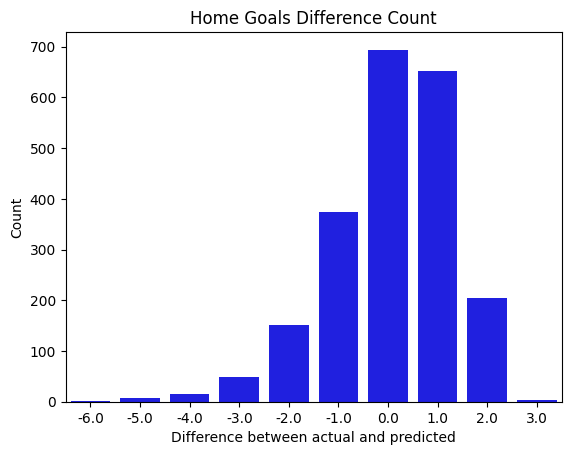

In [55]:
visualisations.histoplot(x_test, ha='Home')

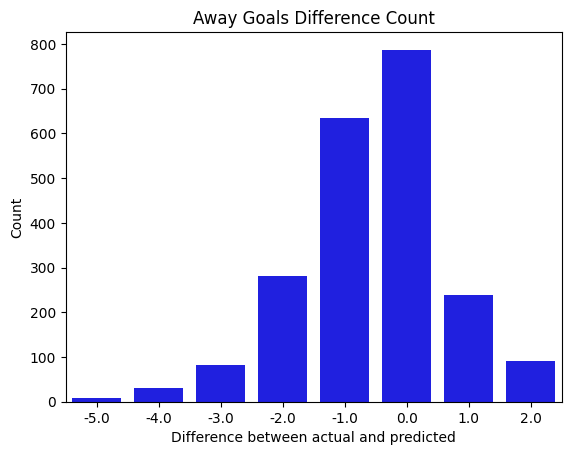

In [56]:
visualisations.histoplot(x_test, ha='Away')

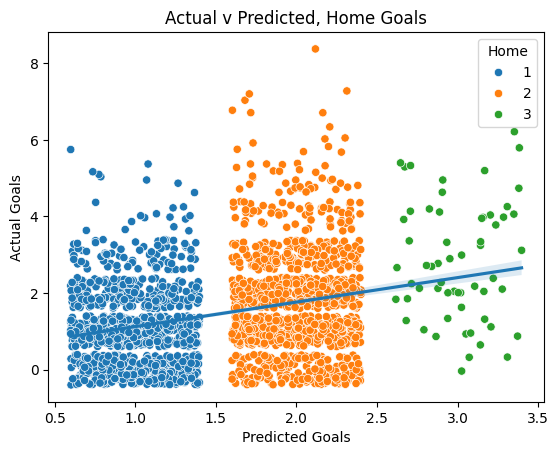

In [57]:
visualisations.actuals_predicted(x_test, ha='Home')

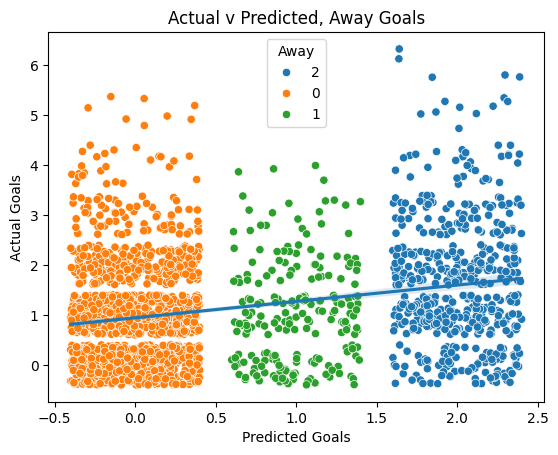

In [58]:
visualisations.actuals_predicted(x_test, ha='Away')

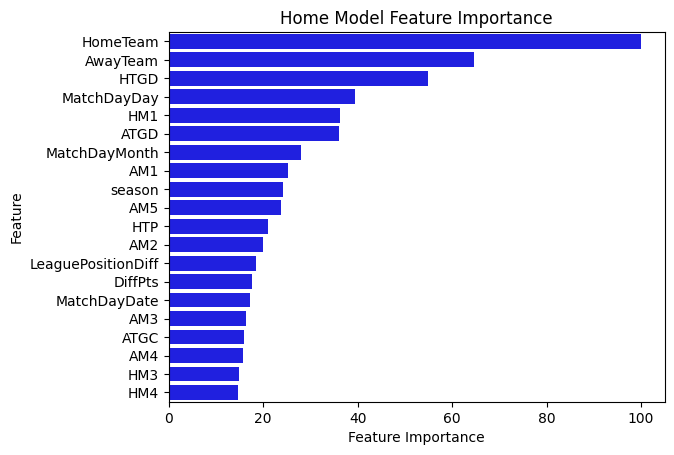

In [59]:
visualisations.plot_features(regressor_1, 'Home',n=20)

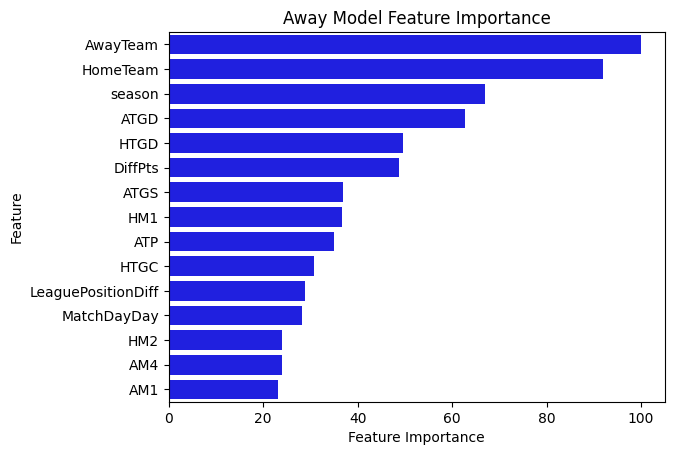

In [60]:
visualisations.plot_features(regressor_2, 'Away')